In [1]:
import tensorflow as tf
import numpy as np
import math
na = np.newaxis
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

# import helper functions from utils.py:
from utils import train_parameters, evaluation, tf_tril_indices, load_lookup_table, table_lookup_op_parallel, get_scp_samples, build_graph, build_eval_graph

# Planning:
- get test examples to run, handle ind point limitations
- get real world dataset example to run

### BUGS:

- nans occur for too many ind points (in exp gradient)
- m and S values go to infinity if inducing_point_res >= 9

(solved?)

- implemented logdet for kl div, added stabilizer


### TODOS:
- clean code into functions
- Check T region definition (currently limits of inducing points)


- calculate and print lower bound for testset
- improve 2d sampling function
- optimize Lookup Table resolution (Max)

# 2d example

In [2]:
from scipy.stats import multivariate_normal

def double_blob(x):
    blob_1 = multivariate_normal.pdf(x, mean = [3, 3], cov=[[1, 0], [0, 1]])
    blob_2 = multivariate_normal.pdf(x, mean = [7, 7], cov=[[1, 0], [0, 1]])
    return (blob_1 + blob_2) * 10

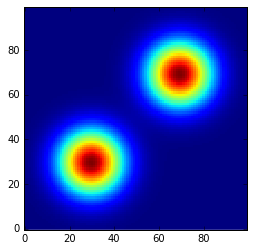

In [3]:
res = 100

Tmin = 0
Tmax = 10

xx, yy = np.meshgrid(np.linspace(Tmin, Tmax, res), np.linspace(Tmin, Tmax, res))

X = np.array([xx, yy]).transpose(1,2,0).reshape(res**2, 2)
vals = double_blob(X).reshape(res,res)

plt.imshow(vals, interpolation='none', origin='lower')
plt.show()

In [4]:
samples, _, _, _, _, _ = get_scp_samples(double_blob, np.array([[Tmin, Tmax], [Tmin,Tmax]]), 10)

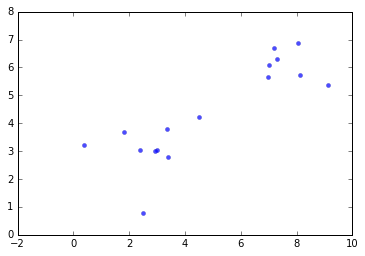

In [5]:
# sampled data:
plt.scatter(samples[:,0], samples[:,1], linewidth=0.1, alpha=.7)
plt.show()

# Variational Approximation

#### Evaluation with learned alphas and increasing number of inducing points

ind point number:  3
alphas:  [ 1.  1.]
gamma:  0.3


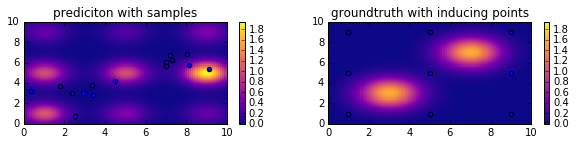

ind point number:  4
alphas:  [ 1.  1.]
gamma:  0.3


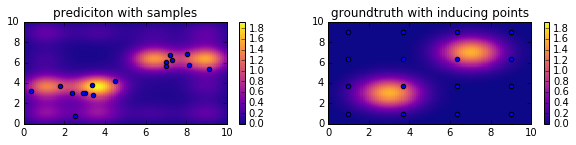

In [6]:
train_hyperparameters = False

#evaluation grid
eval_res = 100
eval_x = np.linspace(Tmin, Tmax, eval_res)[:,na]
eval_y = np.linspace(Tmin, Tmax, eval_res)[:,na]
xx_eval, yy_eval = np.meshgrid(eval_x, eval_y)
eval_grid = np.array([xx_eval, yy_eval]).transpose(1,2,0).reshape(eval_res**2, 2)

ind_point_nums = [3, 4]

counter = 1
for i in ind_point_nums: 
    
    m_opt, S_opt, Kzz_inv_opt, alphas_opt, Z_opt,gamma_opt = train_parameters(samples, i, train_hyperparameters=train_hyperparameters)
    lam_vals = evaluation(m_opt,S_opt,Kzz_inv_opt,alphas_opt,gamma_opt,Z_opt,eval_grid)

    #plots
    cmap = plt.get_cmap('plasma')

    fig = plt.figure(figsize=(10,15)) 

    max_value = np.max([np.max(vals), np.max(lam_vals)])
    norm = mpl.colors.Normalize(vmin=0, vmax=max_value)

    print("ind point number: ",i)
    print("alphas: ",alphas_opt)
    print("gamma: ",gamma_opt)
    ax0 = ax0 = plt.subplot(7,2,counter)
    im = ax0.pcolormesh(xx_eval, yy_eval, lam_vals.reshape(eval_res,eval_res), cmap=cmap, norm=norm)
    fig.colorbar(im, ax=ax0)
    ax0.set_title('prediciton with samples')
    ax0.scatter(samples[:,0], samples[:,1])
    plt.xlim(Tmin, Tmax)
    plt.ylim(Tmin, Tmax)

    ax1 = ax0 = plt.subplot(7,2,counter+1)
    im1 = ax1.pcolormesh(xx, yy, vals, cmap=cmap,norm=norm)
    fig.colorbar(im1, ax=ax1)
    ax1.set_title('groundtruth with inducing points')
    ax1.scatter(Z_opt[:, 0], Z_opt[:,1])
    plt.xlim(Tmin, Tmax)
    plt.ylim(Tmin, Tmax)
    counter += 2
    #plt.savefig('results/' + run_prefix + '_result.png', dpi=300)
    plt.show()